<h1> NAMA : DENI PRIYADI <br>
<h1> ALAMAT : KABUPATEN MAJALENGKA

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'nadyana/flowers'

100% 636M/636M [00:33<00:00, 21.7MB/s]
100% 636M/636M [00:33<00:00, 20.2MB/s]


In [2]:
!pip install keras_preprocessing
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.1 MB/s eta 0:00:00


In [3]:
import zipfile
import os
import splitfolders
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import keras_preprocessing
from PIL import Image
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.applications import Xception, ResNet152V2

In [4]:
target_file = '/content/flowers.zip'
extracting = zipfile.ZipFile(target_file, 'r')
extracting.extractall('/content/flowers')
extracting.close()

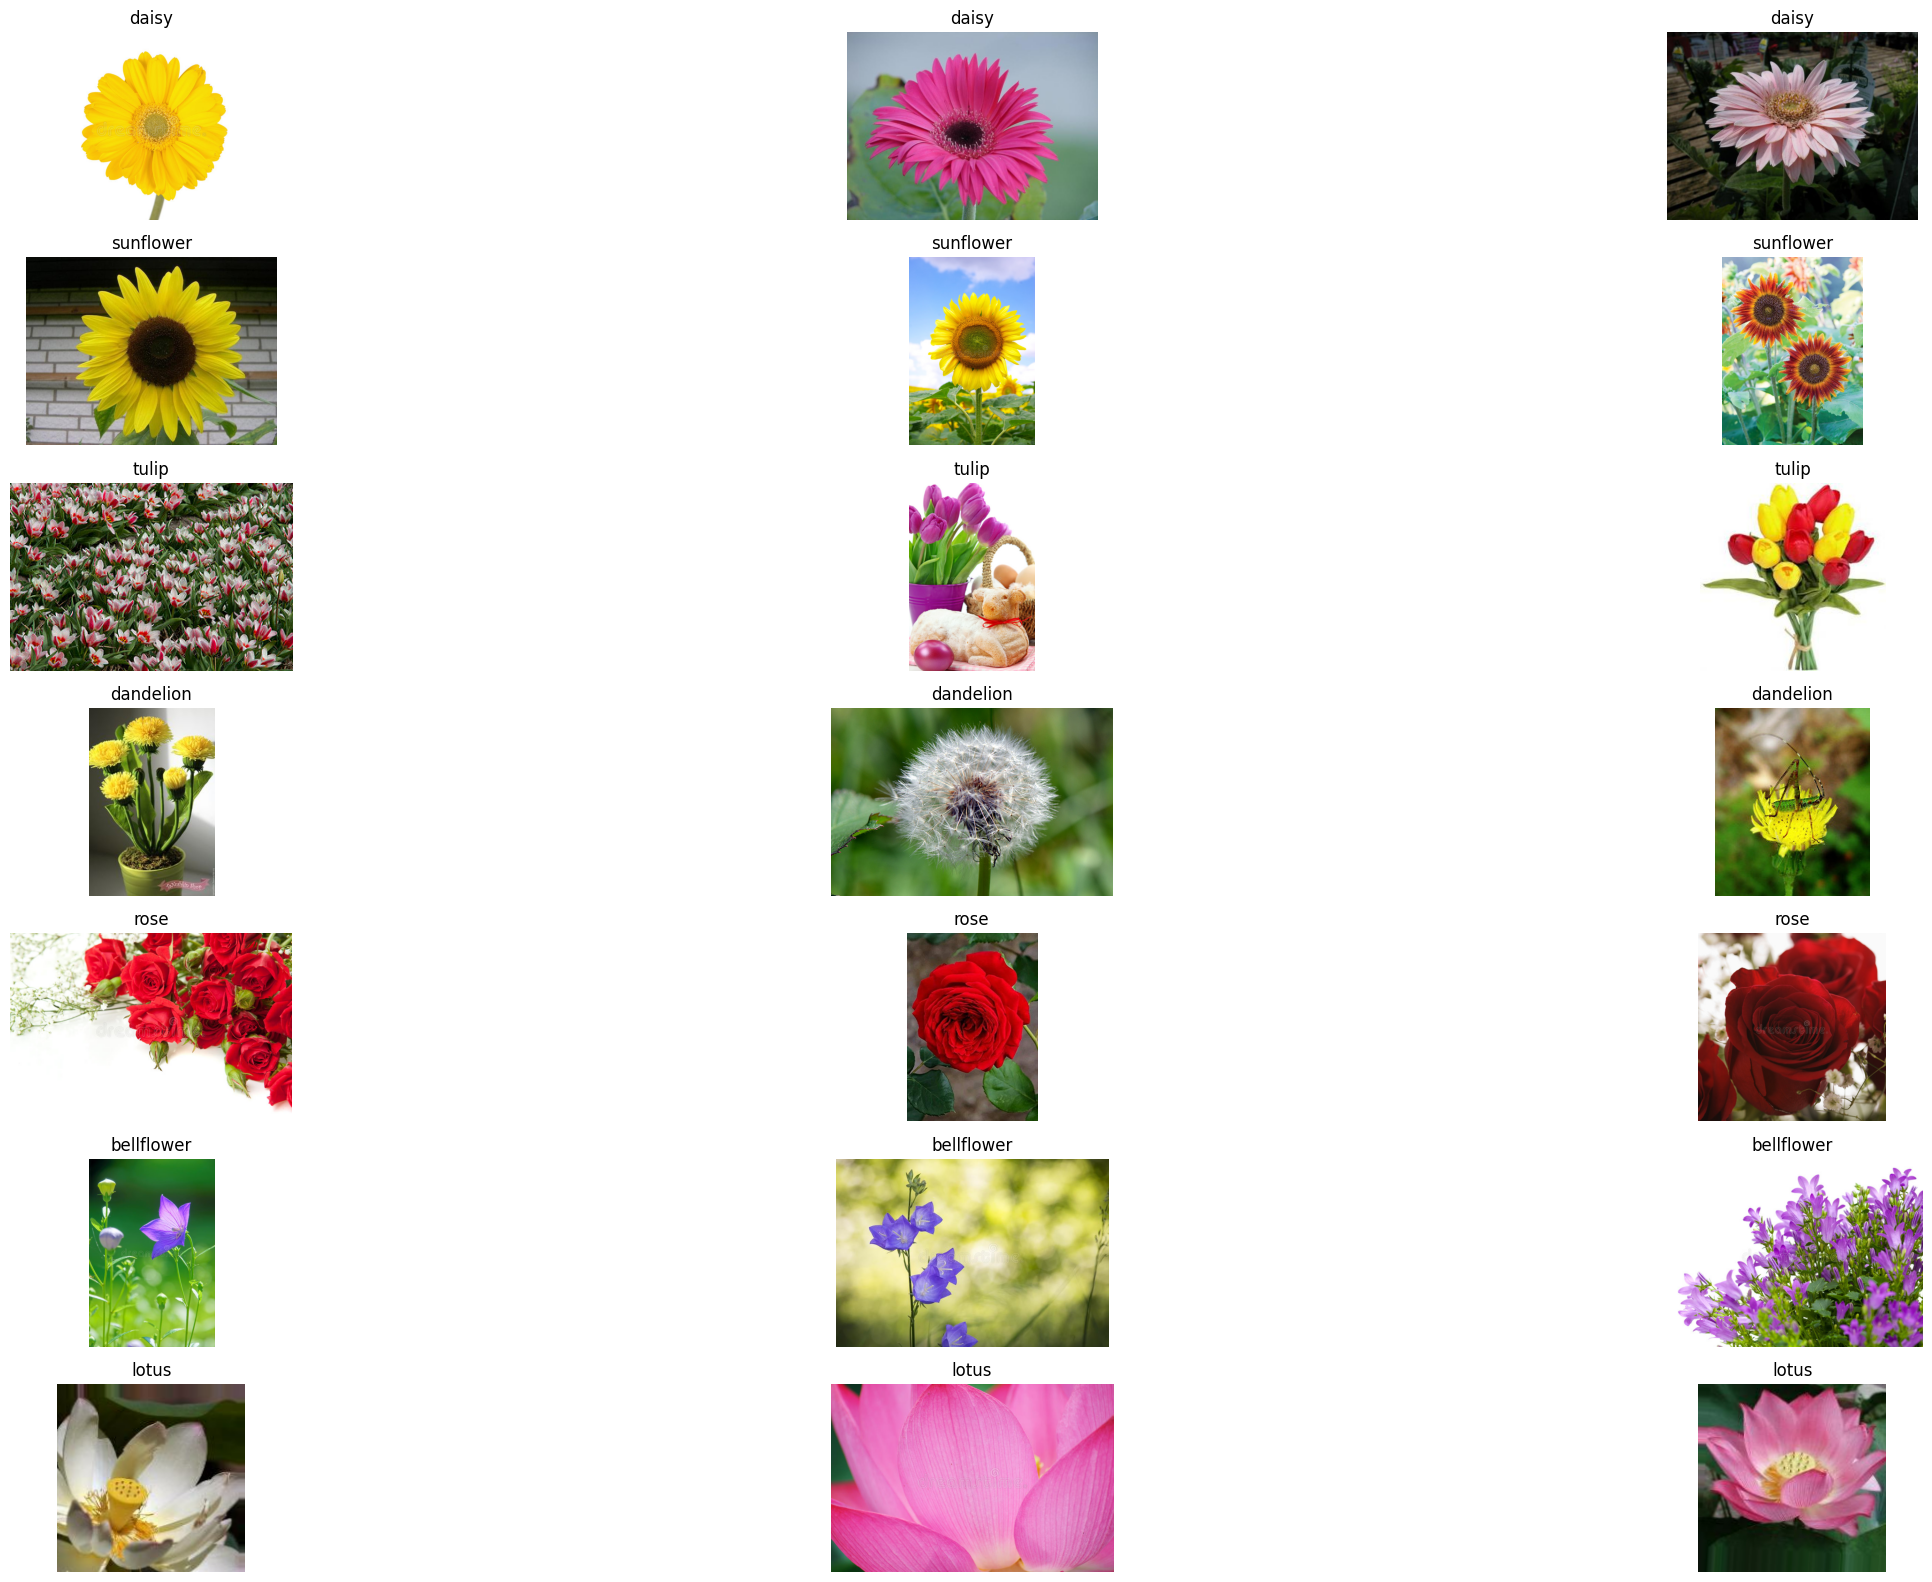

In [5]:
dataset_dir = '/content/flowers/flowers'
classes = os.listdir(dataset_dir)
plt.figure(figsize=(30, 20))

for i, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    img_paths = [os.path.join(class_dir, img) for img in os.listdir(class_dir)[:3]]  # Mengambil 3 gambar pertama dari setiap kelas

    for j, img_path in enumerate(img_paths):
        img = Image.open(img_path)
        plt.subplot(len(classes), 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.show()

In [6]:
splitfolders.ratio(dataset_dir, output=dataset_dir, seed=1337, ratio=(0.8, 0.2))

train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

Copying files: 11200 files [00:05, 2232.98 files/s]


In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 15,
    vertical_flip = True,
    fill_mode = 'nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 16
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 16
)

Found 8960 images belonging to 7 classes.
Found 2240 images belonging to 7 classes.


In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch,logs= {}):
    if(logs.get('accuracy') >= 0.99):
      print ("accuracy sudah mencapai 98%")
      self.model.stop_training = True

In [9]:
width_shape = 128
height_shape = 128

image = Input(shape=(width_shape, height_shape, 3))
base_model = ResNet152V2(input_tensor=image, include_top=False, weights='imagenet')

234545216/234545216 [==============================] - 12s 0us/step


In [10]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                        

In [11]:
modelResnet3= tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1150, activation ='relu'),
    tf.keras.layers.Dropout(0,8),
    tf.keras.layers.Dense(950, activation ='relu'),
    tf.keras.layers.Dropout(0,7),
    tf.keras.layers.Dense(750, activation ='relu'),
    tf.keras.layers.Dropout(0,5),
    tf.keras.layers.Dense(512, activation ='relu'),
    tf.keras.layers.Dropout(0,5),
    #tf.keras.layers.Dense(350, activation ='relu'),
    #tf.keras.layers.Dropout(0,3),
    #tf.keras.layers.Dense(32, activation ='relu'),
    #tf.keras.layers.Dropout(0,5),
    tf.keras.layers.Dense(7, activation = 'softmax')
])

base_model.trainable = False

modelResnet3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1150)              37684350  
                                                                 
 dropout (Dropout)           (None, 1150)              0         
                                                                 
 dense_1 (Dense)             (None, 950)               1093450   
                                                                 
 dropout_1 (Dropout)         (None, 950)               0         
                                                                 
 dense_2 (Dense)             (None, 750)               7

In [12]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001)
modelResnet3.compile (loss = 'categorical_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])

history = modelResnet3.fit (
    train_generator,
    epochs=100,
    validation_data= validation_generator,
    batch_size = 16,
    verbose = 2,
    callbacks = [myCallback()]
)

Epoch 1/100
560/560 - 109s - loss: 1.5671 - accuracy: 0.4442 - val_loss: 1.2374 - val_accuracy: 0.5946 - 109s/epoch - 194ms/step
Epoch 2/100
560/560 - 92s - loss: 1.0643 - accuracy: 0.6515 - val_loss: 0.9532 - val_accuracy: 0.6835 - 92s/epoch - 163ms/step
Epoch 3/100
560/560 - 91s - loss: 0.8562 - accuracy: 0.7190 - val_loss: 0.8312 - val_accuracy: 0.7263 - 91s/epoch - 162ms/step
Epoch 4/100
560/560 - 92s - loss: 0.7527 - accuracy: 0.7507 - val_loss: 0.7343 - val_accuracy: 0.7567 - 92s/epoch - 164ms/step
Epoch 5/100
560/560 - 92s - loss: 0.6837 - accuracy: 0.7761 - val_loss: 0.6900 - val_accuracy: 0.7746 - 92s/epoch - 165ms/step
Epoch 6/100
560/560 - 92s - loss: 0.6222 - accuracy: 0.7967 - val_loss: 0.6621 - val_accuracy: 0.7656 - 92s/epoch - 164ms/step
Epoch 7/100
560/560 - 92s - loss: 0.5819 - accuracy: 0.8117 - val_loss: 0.6116 - val_accuracy: 0.7933 - 92s/epoch - 165ms/step
Epoch 8/100
560/560 - 92s - loss: 0.5592 - accuracy: 0.8166 - val_loss: 0.6041 - val_accuracy: 0.7996 - 92s/e

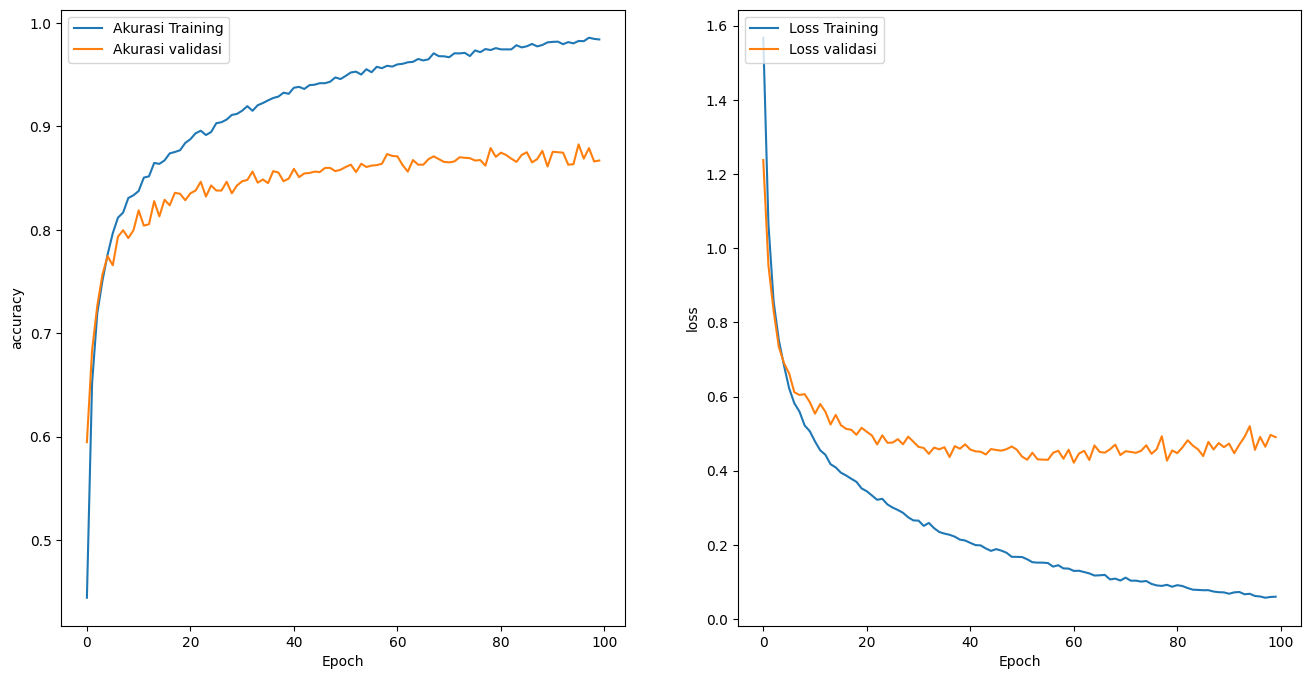

In [13]:
%matplotlib inline

import matplotlib.image as mimg
import matplotlib.pyplot as plt

acc = (history.history['accuracy'])
val_acc = (history.history['val_accuracy'])
loss = (history.history['loss'])
val_loss = (history.history['val_loss'])

plt.figure(figsize = (16,8))
plt.subplot(1,2,1)

plt.plot(acc, label = 'Akurasi Training')
plt.plot(val_acc, label = 'Akurasi validasi')
plt.title = ('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(loss, label = 'Loss Training')
plt.plot(val_loss, label = 'Loss validasi')
plt.title = ('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc = 'upper left')

plt.show()

In [14]:
export_dir = 'model/'
tf.saved_model.save(modelResnet3, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('modelresnet.tflite')
tflite_model_file.write_bytes(tflite_model)

392328076